# Shell element Response

In [1]:
import numpy as np
import openseespy.opensees as ops
import opstool as opst
import matplotlib.pyplot as plt

The original Tcl file comes from http://www.dinochen.com/, and the Python version is converted by opstool.tcl2py().


OPSTOOL ::  Model data has been saved to _OPSTOOL_ODB/ModelData-None.nc!

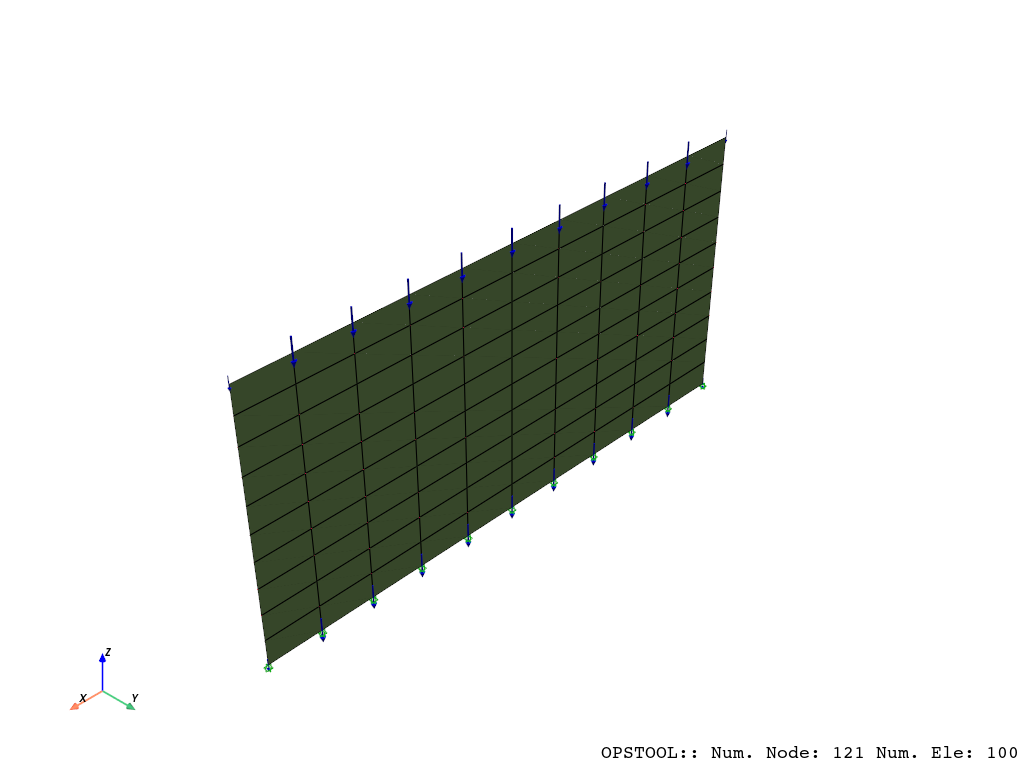

In [2]:
opst.load_ops_examples("Shell3D")  # or your model code here

# add beam loads
ops.timeSeries("Linear", 1)
ops.pattern("Plain", 1, 1)
opst.pre.gen_grav_load(direction="z", factor=-9810)


# plot
opst.vis.pyvista.set_plot_props(notebook=True)
fig = opst.vis.pyvista.plot_model(show_nodal_loads=True, show_ele_loads=True)
fig.show(jupyter_backend="static")

## Result Saving

In [3]:
ops.system("BandGeneral")
# Create the constraint handler, the transformation method
ops.constraints("Transformation")
# Create the DOF numberer, the reverse Cuthill-McKee algorithm
ops.numberer("RCM")
# Create the convergence test, the norm of the residual with a tolerance of
# 1e-12 and a max number of iterations of 10
ops.test("NormDispIncr", 1.0e-12, 10, 3)
# Create the solution algorithm, a Newton-Raphson algorithm
ops.algorithm("Newton")
# Create the integration scheme, the LoadControl scheme using steps of 0.1
ops.integrator("LoadControl", 0.1)
# Create the analysis object
ops.analysis("Static")

In [4]:
ODB = opst.post.CreateODB(odb_tag=1)
for i in range(10):
    ops.analyze(1)
    ODB.fetch_response_step()
ODB.save_response()

OPSTOOL ::  All responses data with odb_tag = 1 saved in _OPSTOOL_ODB/RespStepData-1.nc!

## Result Reading

In [5]:
all_resp = opst.post.get_element_responses(odb_tag=1, ele_type="Shell")

OPSTOOL ::  Loading response data from _OPSTOOL_ODB/RespStepData-1.nc ...

The result is an ``xarray DataSet`` object, and we can access the associated DataArray objects through ``.data_vars``.

In [6]:
all_resp.data_vars

Data variables:
    sectionForces        (time, eleTags, GaussPoints, secDOFs) float64 282kB ...
    sectionDeformations  (time, eleTags, GaussPoints, secDOFs) float64 282kB ...
    Stresses             (time, eleTags, GaussPoints, fiberPoints, stressDOFs) float64 880kB ...
    Strains              (time, eleTags, GaussPoints, fiberPoints, stressDOFs) float64 880kB ...

``section forces`` and ``deformations`` at Gauss points are supported, representing the shell section response per unit length.

``Stresses`` and ``Strains`` refer to the fiber stress and strain at the Gauss points. 
``fiberPoints`` represents the fiber No. on each section at the Gauss point, typically counted from the bottom.
Stress and strain have five components, because sigma33 (the normal stress along the local z-axis) is zero and omitted.
The remaining components represent stresses along the local directions.

In [7]:
all_resp.attrs  # attributes

{'FXX,FYY,FXY': 'Membrane (in-plane) forces or deformations.',
 'MXX,MYY,MXY': 'Bending moments or rotations (out-plane) of plate.',
 'VXZ,VYZ': 'Shear forces or deformations.',
 'sigma11, sigma22': 'Normal stress (strain) along local x, y',
 'sigma12, sigma23, sigma13': 'Shear stress (strain).'}

### Section response

In [8]:
sec_forces = all_resp["sectionForces"]
sec_forces

<xarray.DataArray 'sectionForces' (time: 11, eleTags: 100, GaussPoints: 4,
                                   secDOFs: 8)> Size: 282kB
[35200 values with dtype=float64]
Coordinates:
  * eleTags      (eleTags) int32 400B 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
  * GaussPoints  (GaussPoints) int32 16B 1 2 3 4
  * secDOFs      (secDOFs) <U3 96B 'FXX' 'FYY' 'FXY' 'MXX' ... 'MXY' 'VXZ' 'VYZ'
  * time         (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

Let's take a look at the various coordinates.

In [9]:
sec_forces.coords

Coordinates:
  * eleTags      (eleTags) int32 400B 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
  * GaussPoints  (GaussPoints) int32 16B 1 2 3 4
  * secDOFs      (secDOFs) <U3 96B 'FXX' 'FYY' 'FXY' 'MXX' ... 'MXY' 'VXZ' 'VYZ'
  * time         (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0

In [10]:
sec_forces.coords["eleTags"].data  # all element tags

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100])

In [11]:
sec_forces.coords["secDOFs"].data  # all section DOFs

array(['FXX', 'FYY', 'FXY', 'MXX', 'MYY', 'MXY', 'VXZ', 'VYZ'],
      dtype='<U3')

Below, we select the membrane force $F_{YY}$ of element 1.

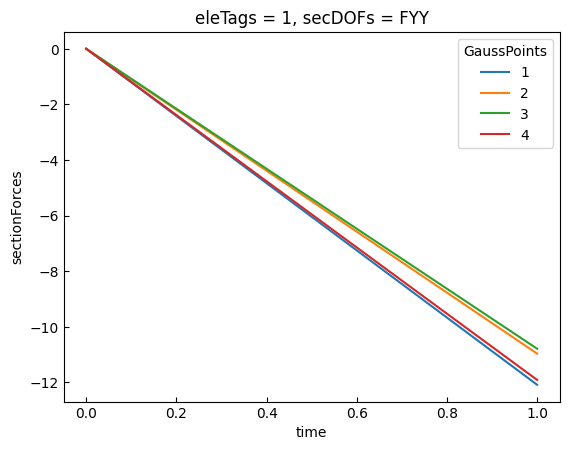

In [12]:
sec_forces_fxx = sec_forces.sel(
    eleTags=1,
    secDOFs="FYY",
)
# plot
sec_forces_fxx.plot.line(
    x="time",
)
plt.show()

### Stresses and Strains

Below, we retrieve the stress and strain data, which is a **five-dimensional** array.
The dimensions are, in order, **('time', 'eleTags', 'GaussPoints', 'fiberPoints', 'stressDOFs')**, and we can conveniently retrieve data based on these dimensions and their coordinates.

In [13]:
stresses = all_resp["Stresses"]
strains = all_resp["Strains"]
print(stresses)
print("=" * 100)
print(strains)
print("=" * 100)
print(stresses.dims)

<xarray.DataArray 'Stresses' (time: 11, eleTags: 100, GaussPoints: 4,
                              fiberPoints: 5, stressDOFs: 5)> Size: 880kB
[110000 values with dtype=float64]
Coordinates:
  * eleTags      (eleTags) int32 400B 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
  * GaussPoints  (GaussPoints) int32 16B 1 2 3 4
  * fiberPoints  (fiberPoints) int32 20B 1 2 3 4 5
  * stressDOFs   (stressDOFs) <U7 140B 'sigma11' 'sigma22' ... 'sigma13'
  * time         (time) float64 88B 0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0
<xarray.DataArray 'Strains' (time: 11, eleTags: 100, GaussPoints: 4,
                             fiberPoints: 5, stressDOFs: 5)> Size: 880kB
[110000 values with dtype=float64]
Coordinates:
  * eleTags      (eleTags) int32 400B 1 2 3 4 5 6 7 8 ... 94 95 96 97 98 99 100
  * GaussPoints  (GaussPoints) int32 16B 1 2 3 4
  * fiberPoints  (fiberPoints) int32 20B 1 2 3 4 5
  * stressDOFs   (stressDOFs) <U7 140B 'sigma11' 'sigma22' ... 'sigma13'
  * time         (time) float64 

In [14]:
stresses2 = stresses.sel(eleTags=1, stressDOFs="sigma22")
strains2 = strains.sel(eleTags=1, stressDOFs="sigma22")
gauss_points = stresses2.coords["GaussPoints"].data
fiber_points = stresses2.coords["fiberPoints"].data

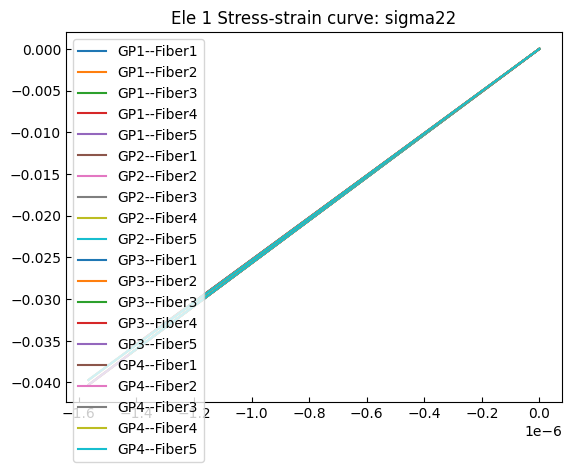

In [15]:
for gp_no in gauss_points:
    for fiber_no in fiber_points:
        s = stresses2.sel(GaussPoints=gp_no, fiberPoints=fiber_no)
        d = strains2.sel(GaussPoints=gp_no, fiberPoints=fiber_no)
        plt.plot(d, s, label=f"GP{gp_no}--Fiber{fiber_no}")
plt.title("Ele 1 Stress-strain curve: sigma22")
plt.legend()
plt.show()

We can also compute averages along a specific dimension. For example, below, we calculate the average stress at the Gauss points:

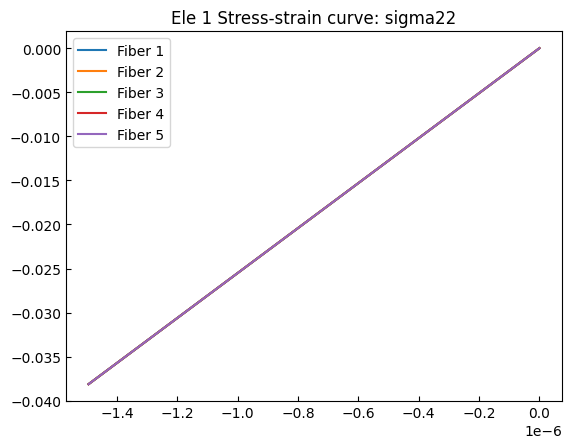

In [16]:
stresses3 = stresses2.mean(dim="GaussPoints")
strains3 = strains2.mean(dim="GaussPoints")

for fiber_no in fiber_points:
    s = stresses3.sel(fiberPoints=fiber_no)
    d = strains3.sel(fiberPoints=fiber_no)
    plt.plot(d, s, label=f"Fiber {fiber_no}")
plt.title("Ele 1 Stress-strain curve: sigma22")
plt.legend()
plt.show()